In [47]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Lectura de datos

In [48]:
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()


,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## First visualitation

In [49]:
air_passengers_ts = TimeSeriesData(air_passengers_df)

# First comparative

## Individual models

In [50]:
## HYPERPARAMETERS
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData


from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

### sarima

<AxesSubplot: xlabel='time', ylabel='y'>

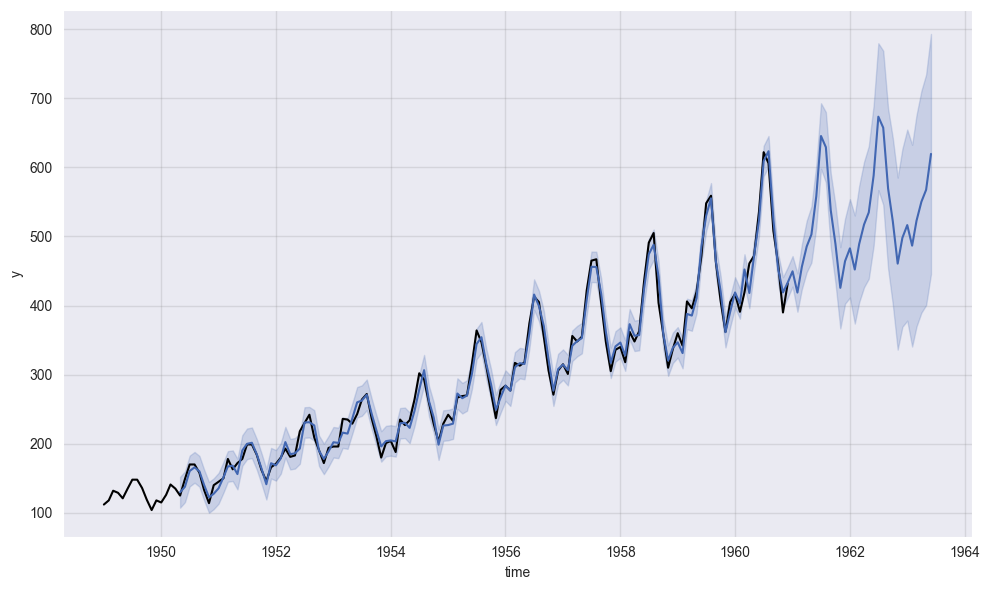

In [62]:
warnings.simplefilter(action='ignore')
from kats.models.sarima import SARIMAModel, SARIMAParams

# create SARIMA param class
sarima_params = SARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    trend = 'ct', #both linear or constant
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=sarima_params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### arima

<AxesSubplot: xlabel='time', ylabel='y'>

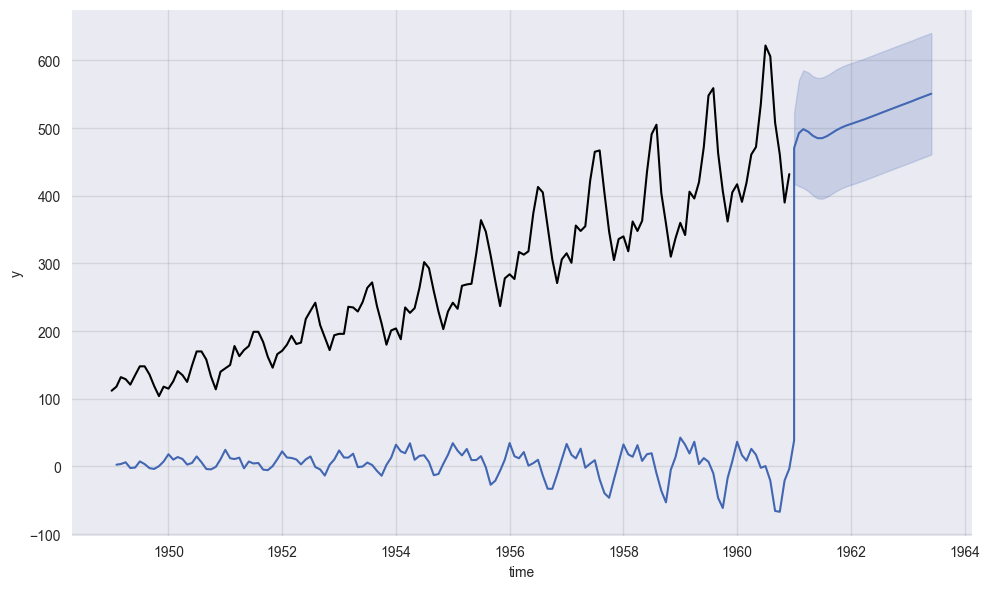

In [63]:
from kats.models.arima import ARIMAParams, ARIMAModel
# create ARIMA param class
arima_params = ARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    )

# initiate SARIMA model
m = ARIMAModel(data=air_passengers_ts, params=arima_params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot: xlabel='time', ylabel='y'>

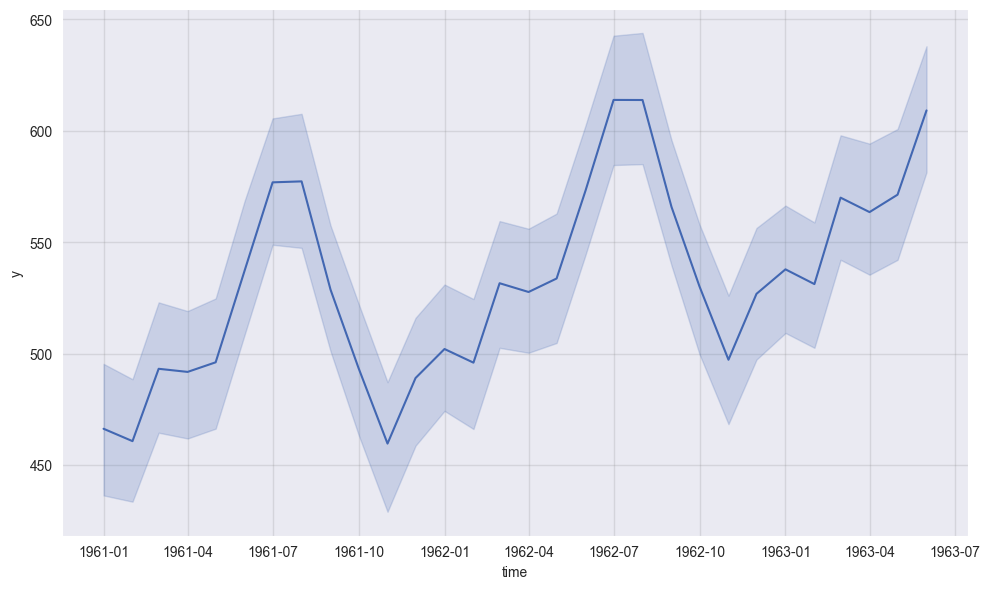

In [64]:
# # import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams
# create a model param instance
prophet_params = ProphetParams(seasonality_mode='additive') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, prophet_params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

### holt-winter

<AxesSubplot: xlabel='time', ylabel='y'>

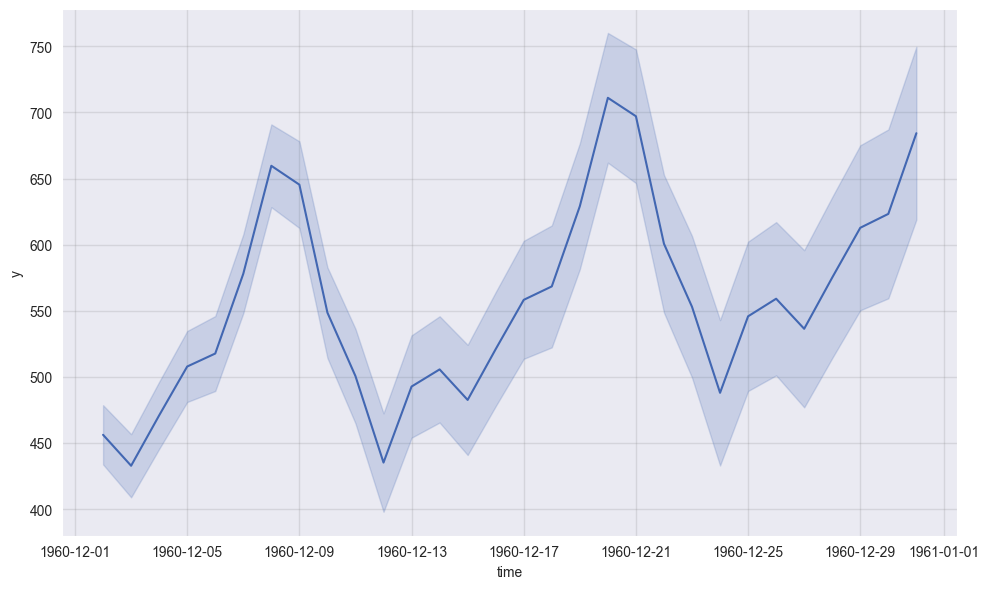

In [65]:
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams
warnings.simplefilter(action='ignore')


holt_params = HoltWintersParams(
            trend="mul",
            damped=False,
            seasonal="add",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=holt_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### lstm

<AxesSubplot: xlabel='time', ylabel='y'>

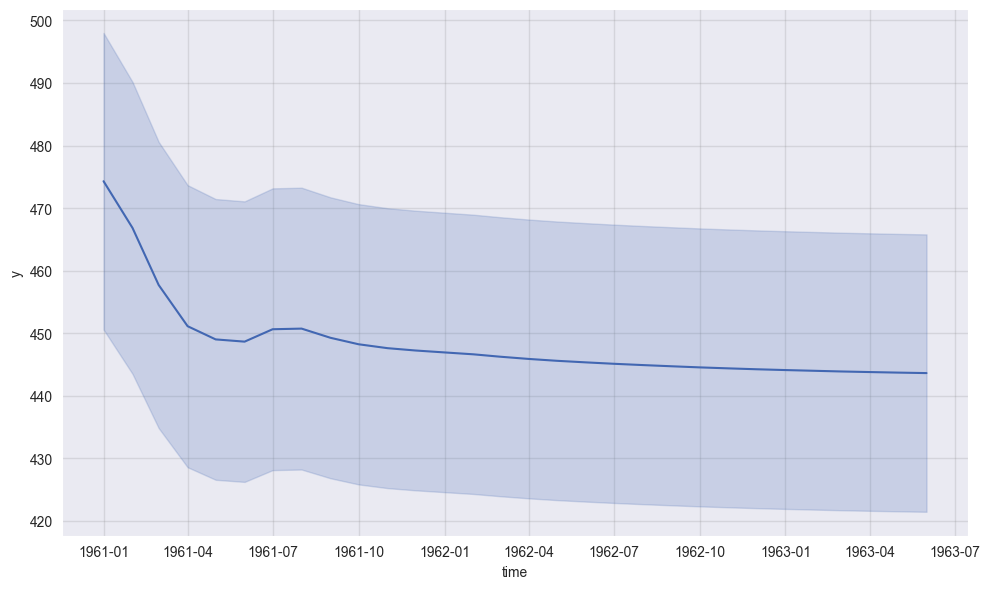

In [66]:
warnings.simplefilter(action='ignore')
from kats.models.lstm import LSTMParams, LSTMModel

lstm_params = LSTMParams(
            hidden_size=70,
            time_window=7,
            num_epochs=3
        )
m = LSTMModel(
    data=air_passengers_ts, 
    params=lstm_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### thetha

<AxesSubplot: xlabel='time', ylabel='y'>

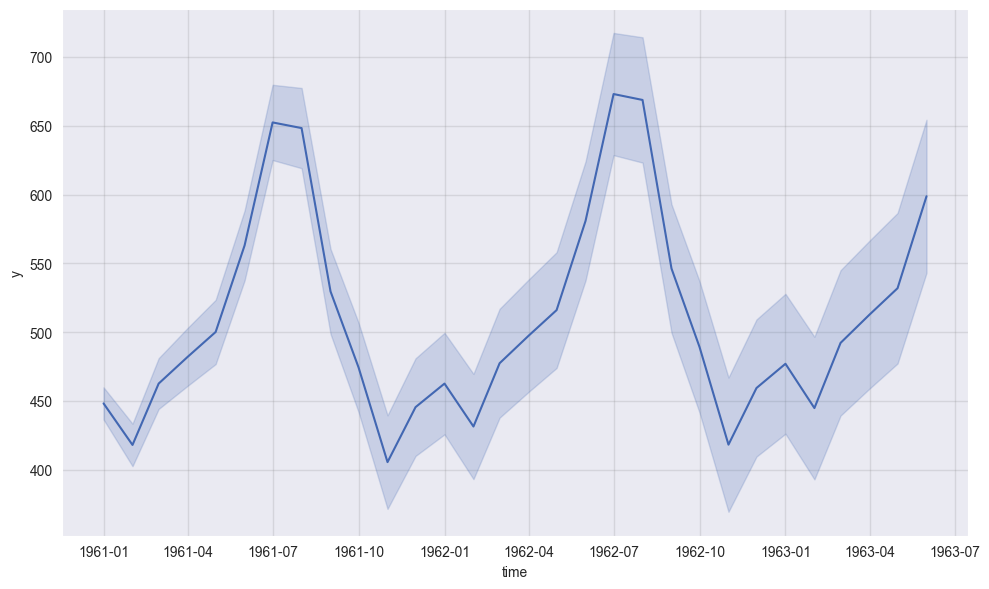

In [67]:
# No es necesario hacer un grid, sabemos que la estacionalidad es 12
from kats.models.theta import ThetaModel, ThetaParams
warnings.simplefilter(action='ignore')

theta_params = ThetaParams(
            m = 12
        )
m = ThetaModel(
    data=air_passengers_ts, 
    params=theta_params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### EVALUACIÓN DE LOS MODELOS 

#### Backtester fixed

In [68]:
from kats.utils.backtesters import BackTesterFixedWindow


backtester_simple_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']
# ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']


In [69]:
backtester_simple_sarima = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= sarima_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15, 
    model_class=SARIMAModel)

backtester_simple_sarima.run_backtest()

backtester_simple_errors['sarima'] = {}
for error, value in backtester_simple_sarima.errors.items():
    backtester_simple_errors['sarima'][error] = value

In [70]:
backtester_simple_arima = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= arima_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15, 
    model_class=ARIMAModel)

backtester_simple_arima.run_backtest()

backtester_simple_errors['arima'] = {}
for error, value in backtester_simple_arima.errors.items():
    backtester_simple_errors['arima'][error] = value

In [71]:
backtester_simple_prophet = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= prophet_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,  
    model_class=ProphetModel)

backtester_simple_prophet.run_backtest()

backtester_simple_errors['prophet'] = {}
for error, value in backtester_simple_prophet.errors.items():
    backtester_simple_errors['prophet'][error] = value

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
backtester_simple_holt = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= holt_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,  
    model_class=HoltWintersModel)

backtester_simple_holt.run_backtest()

backtester_simple_errors['holt'] = {}
for error, value in backtester_simple_holt.errors.items():
    backtester_simple_errors['holt'][error] = value

In [73]:
backtester_simple_lstm = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= lstm_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15, 
    model_class=LSTMModel)

backtester_simple_lstm.run_backtest()

backtester_simple_errors['lstm'] = {}
for error, value in backtester_simple_lstm.errors.items():
    backtester_simple_errors['lstm'][error] = value

In [74]:
backtester_simple_theta = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= theta_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15, 
    model_class=ThetaModel)

backtester_simple_theta.run_backtest()

backtester_simple_errors['theta'] = {}
for error, value in backtester_simple_theta.errors.items():
    backtester_simple_errors['theta'][error] = value

## Ensemble models

In [ ]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
model_ensemble_params = EnsembleParams(
            [
                BaseModelParams("sarima",sarima_params),
                BaseModelParams("arima", arima_params),
                BaseModelParams("prophet", prophet_params),
                BaseModelParams("holtwinters", holt_params),   
                BaseModelParams("theta", theta_params)
                # BaseModelParams("lstm", lstm_params)
            ]
        )

### median

<AxesSubplot: xlabel='time', ylabel='y'>

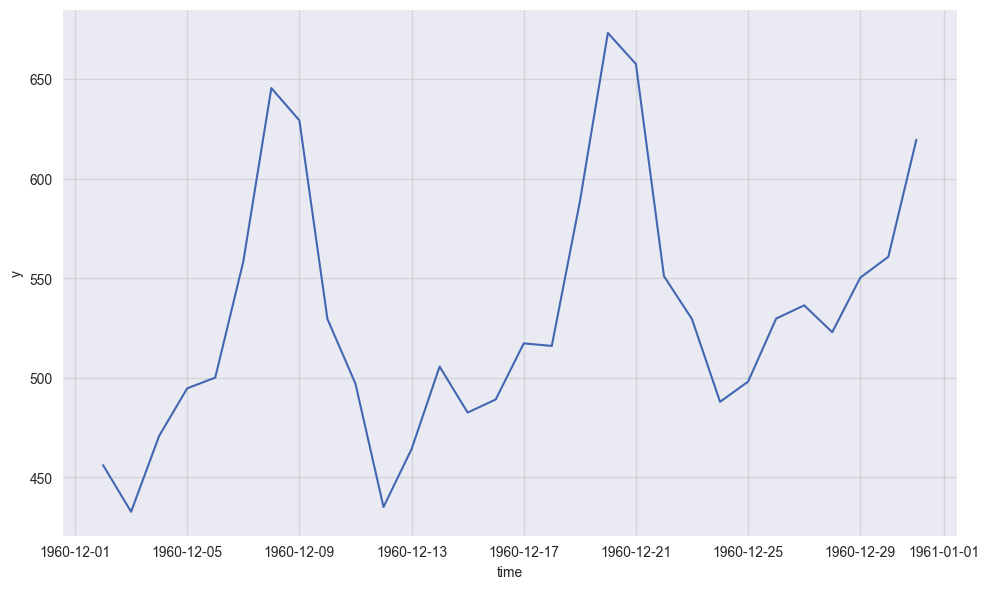

In [75]:
from kats.models.ensemble.median_ensemble import MedianEnsembleModel

m = MedianEnsembleModel(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)
m.plot()

### mean 

<AxesSubplot: xlabel='time', ylabel='y'>

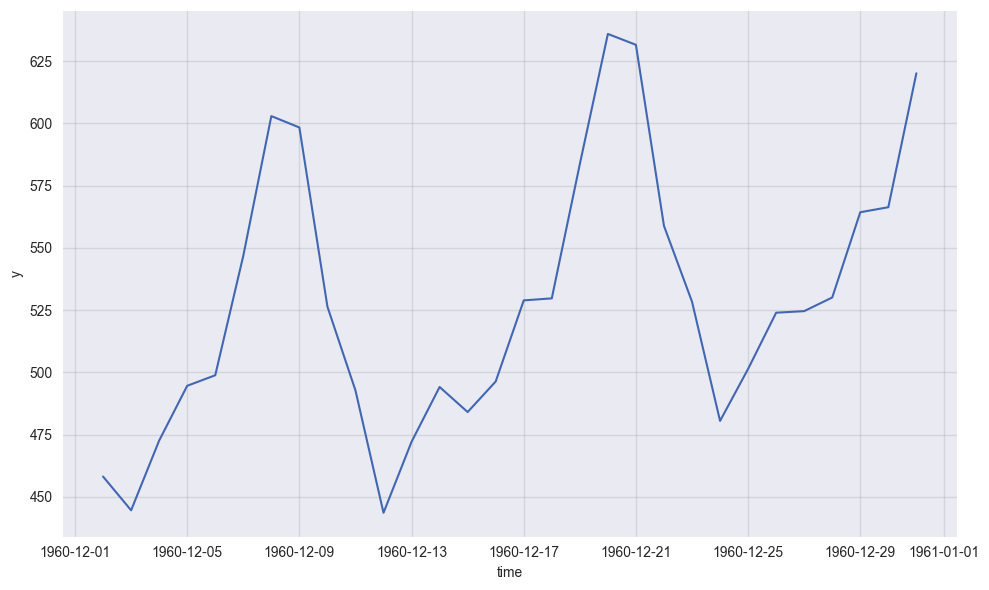

In [76]:
from kats.models.ensemble.mean_ensemble import MeanEnsembleModel

m = MeanEnsembleModel(data = air_passengers_ts, 
                    params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)
m.plot()

### weighted average

<AxesSubplot: xlabel='time', ylabel='y'>

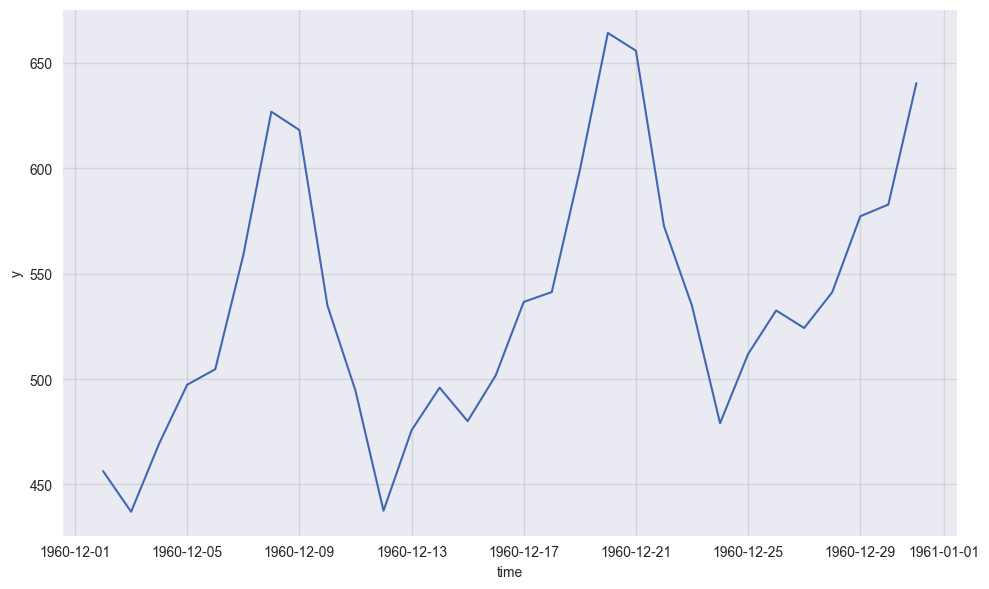

In [77]:
from kats.models.ensemble.weighted_avg_ensemble import WeightedAvgEnsemble

m = WeightedAvgEnsemble(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)

m.plot()

### bates&granger

<AxesSubplot: xlabel='time', ylabel='y'>

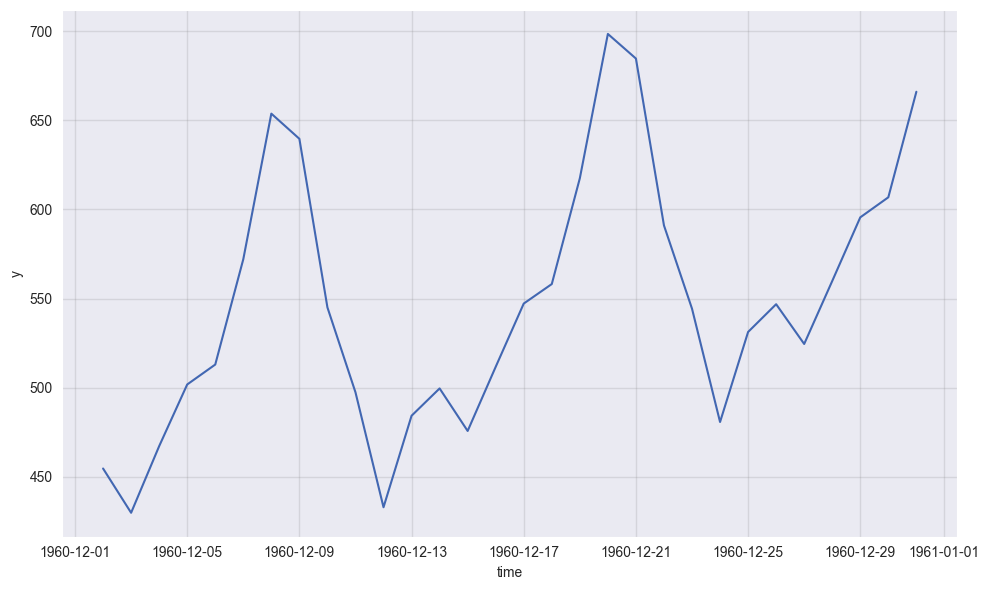

In [78]:
from kats.models.ensemble.bates_granger_ensemble import BatesGrangerEnsemble

m = BatesGrangerEnsemble(data = air_passengers_ts, 
                        params = model_ensemble_params)

m.fit()

p = m.predict(steps=30)

m.plot()

##### Evaluación de modelos

In [79]:
backtester_ensemble_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']


In [80]:
backtester_ensemble_median = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,
    model_class=MedianEnsembleModel)

backtester_ensemble_median.run_backtest()

backtester_ensemble_errors['median'] = {}
for error, value in backtester_ensemble_median.errors.items():
    backtester_ensemble_errors['median'][error] = value

In [81]:
backtester_ensemble_mean = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,
    model_class=MeanEnsembleModel)

backtester_ensemble_mean.run_backtest()

backtester_ensemble_errors['mean'] = {}
for error, value in backtester_ensemble_mean.errors.items():
    backtester_ensemble_errors['mean'][error] = value

In [82]:

backtester_ensemble_weighted_average = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,
    model_class=WeightedAvgEnsemble)

backtester_ensemble_weighted_average.run_backtest()

backtester_ensemble_errors['weighted_average'] = {}
for error, value in backtester_ensemble_weighted_average.errors.items():
    backtester_ensemble_errors['weighted_average'][error] = value

In [83]:

backtester_ensemble_bates_granger = BackTesterFixedWindow(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params= model_ensemble_params,
    train_percentage=75,
    window_percentage=10,
    test_percentage=15,
    model_class=BatesGrangerEnsemble)

backtester_ensemble_bates_granger.run_backtest()

backtester_ensemble_errors['bates&granger'] = {}
for error, value in backtester_ensemble_bates_granger.errors.items():
    backtester_ensemble_errors['bates&granger'][error] = value

## COMPARATIVA FINAL 

In [84]:
pd.DataFrame.from_dict(backtester_simple_errors) 

,sarima,arima,prophet,holt,lstm,theta
mae,20.761662,57.129177,36.465915,44.489341,116.690895,40.278162
mape,0.040913,0.112729,0.080626,0.103139,0.234923,0.084825
mase,0.454303,1.250091,0.797941,0.973509,2.553411,0.881360
mse,819.569025,6113.015358,1853.153883,2459.071159,18906.178651,2187.658679
rmse,28.628116,78.185775,43.048274,49.589023,137.499741,46.772414
smape,0.041923,0.121092,0.078586,0.096733,0.275398,0.089717


In [85]:
pd.DataFrame.from_dict(backtester_ensemble_errors) 

,median,mean,weighted_average,bates&granger
mae,27.592501,26.008803,21.166583,28.377669
mape,0.058344,0.053396,0.044960,0.065579
mase,0.603775,0.569120,0.463164,0.620956
mse,1218.031062,1163.340680,728.640016,1027.923423
rmse,34.900302,34.107780,26.993333,32.061245
smape,0.058265,0.054014,0.044753,0.062923


## PLOTING

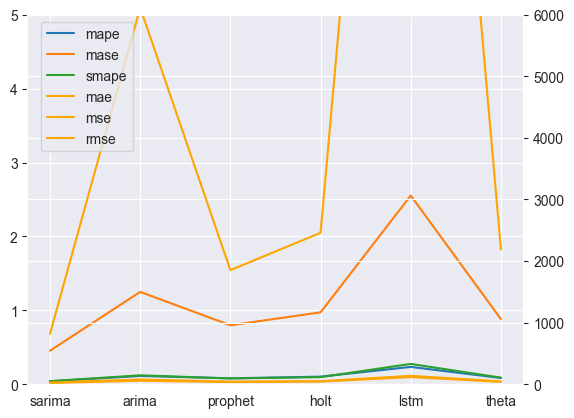

In [86]:
df = pd.DataFrame.from_dict(backtester_simple_errors).T

df[["mape","mase","smape"]]
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set_title("Product Sales and Profits")

fig, ax = plt.subplots()

ax.plot(df[["mape","mase","smape"]], label = ["mape","mase","smape"] )
ax.set_ylim(0, 5)

ax2 = ax.twinx()

ax2.plot(df[["mae","mse","rmse"]], c="orange", label = ["mae","mse","rmse"])
ax2.set_ylim(0, 6000)

fig.legend(bbox_to_anchor=(.3, .88))

plt.show()

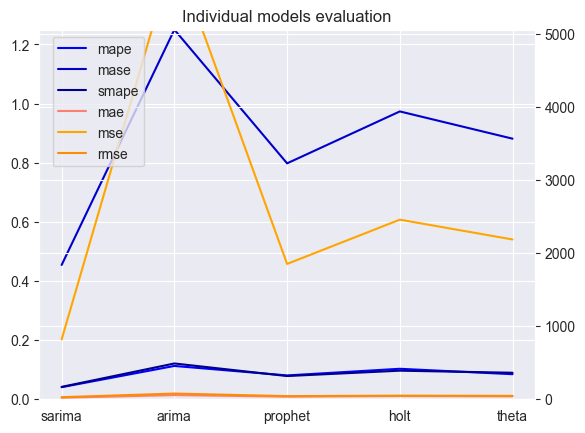

In [87]:
df = pd.DataFrame.from_dict(backtester_simple_errors).drop(['lstm'], axis=1).T

colors = ['blue','mediumblue','darkblue','salmon','orange','darkorange']
col = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots()

for i, column in enumerate(df[["mape","mase","smape"]].columns):
    ax.plot(
        df[col[i]] , 
        color=colors[i],
        label = col[i]
    )

ax.set_ylim(0, 1.25)

ax2 = ax.twinx()

for i, column in enumerate(df[["mae","mse","rmse"]].columns):
    ax2.plot(
        df[col[i+3]] , 
        color=colors[i+3],
        label = col[i+3]
    )

ax2.set_ylim(0, 5060)

fig.legend(bbox_to_anchor=(.3, .88))

ax.set_title('Individual models evaluation')

plt.show()

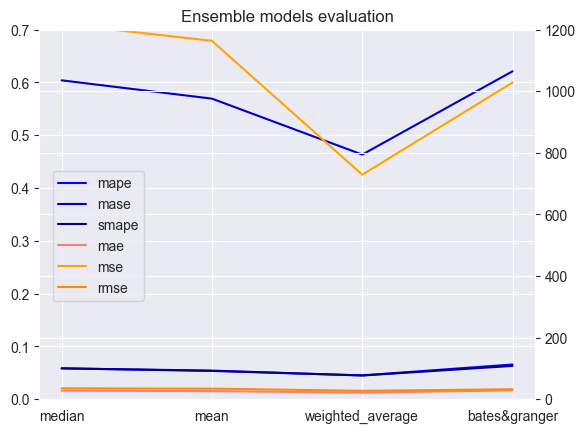

In [88]:
df = pd.DataFrame.from_dict(backtester_ensemble_errors).T

fig, ax = plt.subplots()

for i, column in enumerate(df[["mape","mase","smape"]].columns):
    ax.plot(
        df[col[i]] , 
        color=colors[i],
        label = col[i]
    )

ax.set_ylim(0, 0.7)

ax2 = ax.twinx()

for i, column in enumerate(df[["mae","mse","rmse"]].columns):
    ax2.plot(
        df[col[i+3]] , 
        color=colors[i+3],
        label = col[i+3]
    )

ax2.set_ylim(0, 1200)

fig.legend(bbox_to_anchor=(.3, .6))

ax.set_title('Ensemble models evaluation')

plt.show()

In [90]:
# TODOS JUNTOS 
df_complete = pd.concat([pd.DataFrame.from_dict(backtester_simple_errors).drop(['lstm'], axis=1),pd.DataFrame.from_dict(backtester_ensemble_errors)], axis=1).T

# df_complete.index = ['s','a','p','h','t','me','wa','bg']
# df_complete.index[6] = 'weigh_avg'
# df_complete.index[7] = 'bat_gr'
df_complete.index = ['sarima', 'arima', 'prophet', 'holt', 'theta', 'median','mean','weigh_avg', 'bat_gr']

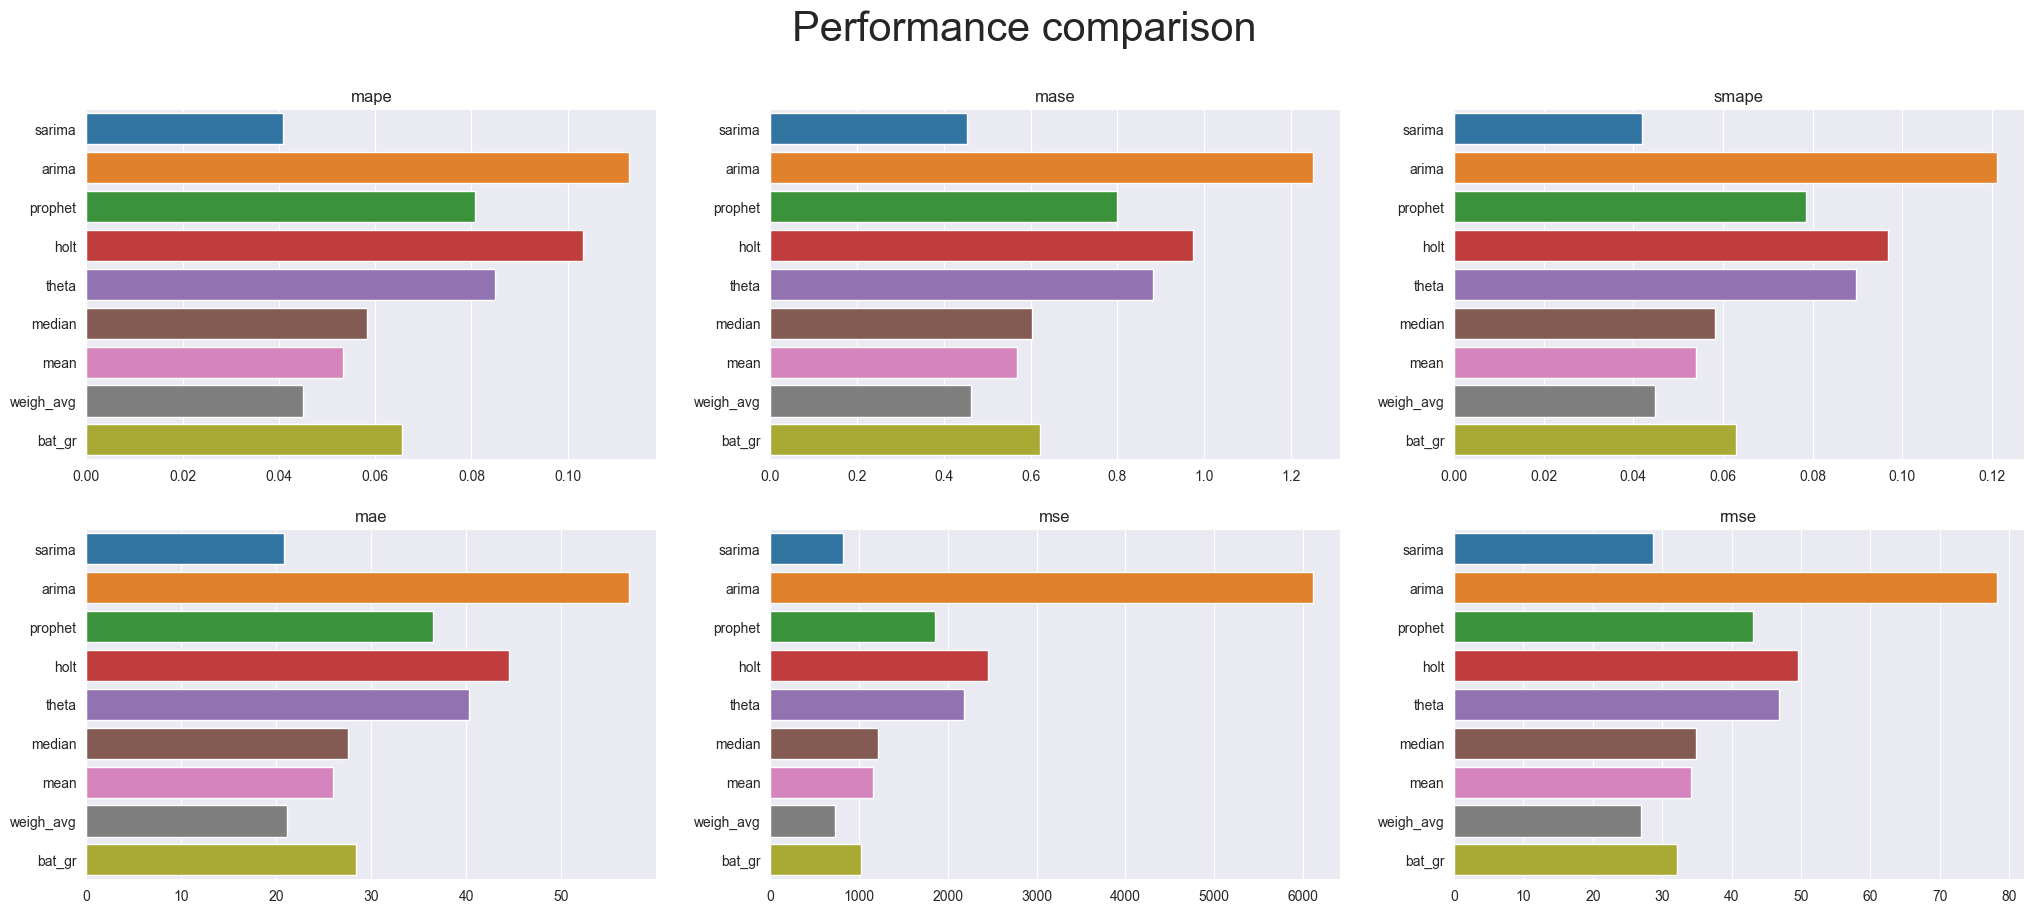

In [92]:
import seaborn as sns

def comparative_barplot(err,i,j):
    sns.set_style("darkgrid")
    p = sns.barplot(
        x = err,
        y = df_complete.index,
        data = df_complete,
        ax = ax[i][j]
        
    )
    p.set(title= err)
    p.set_xlabel('')

error = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots(2, 3)
# plt.rc('font', size = 15)
# fig.suptitle('Comparison of the different types of errors', fontsize = 40, fontfamily ='DejaVu Sans' )


i = 0
for e in error[0:3]:
    comparative_barplot(e,0,i) 
    i = i+1

i = 0
for e in error[3:7]:
    comparative_barplot(e,1,i) 
    i = i+1

# fig.tight_layout()
fig.set_size_inches(25, 10)
fig.suptitle('Performance comparison', fontsize = 30)

plt.savefig('../images/comparative_errors_fixed', bbox_inches='tight')